# Extended demo of glm_utils

In [1]:
from glm_utils.preprocessing import time_delay_embedding, BasisProjection
from glm_utils.bases import raised_cosine, multifeature_basis
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model as lm
import scipy.signal
from demo_utils import get_data
plt.style.use('ncb.mplstyle')

# Get data
In this demo we will work with a response (y) which has been constructed from normalized randomly generated feature (x, 4 inputs) that were filtered with known filters, one for each features.

'Explain what kind of model are we trying to create here: multi-feature model predicting one variable.'

x [time, features]: (5000, 4)
y [time,]: (5000,)
filters [delays, features] (50, 4)


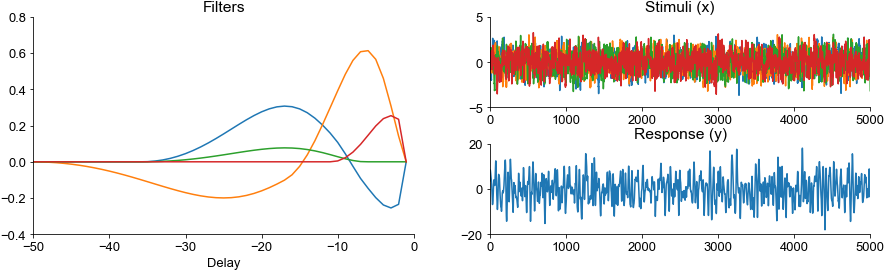

In [2]:
x, y, filters = get_data(npoints = 5000)
npoints, ninputs = x.shape
ndelays = filters.shape[0]
T = np.arange(-ndelays, 0)

print(f"x [time, features]: {x.shape}\ny [time,]: {y.shape}\nfilters [delays, features] {filters.shape}")
plt.figure(figsize=[15,4])
plt.subplot(121)
plt.plot(T, filters)
plt.title('Filters')
plt.xlabel('Delay')
plt.subplot(222)
plt.plot(x)
plt.title('Stimuli (x)')
plt.subplot(224)
plt.plot(y)
plt.title('Response (y)')
plt.subplots_adjust(hspace=0.4)
plt.show()

# Normalize the data

`I know this doesn't do anything since our data are already normalized but may be good just for completeness. Why normalize? How?`


# Time-delay-embedding

`time delay embedding should come before the basis functions - text needs a little updating to fit in the new order`
To project our data, we need to recover not just the desired data point, but also a time window before each data point collected. Luckily, glm_utils also provides a simple function which will take your inputs, signal, and the desired window size (here set to be equal to the window size of our bases, which is required in future steps, although you can collect longer window sizes and preprocess the data to fit the window size before projection).

Note: the size of the outputs will be a reduced version of the inputs, as the window size is too big for the first elements. This shape of the outputs will be missing as many elements as the size of your window.

Tip: for data collected from multiple sources (experiments, individuals, trials, ...), it is recommended to store the time-delay-embedding of the specific data points that you are interested.

In [3]:
# time-delay-embedding
window_size = 50
Xmulti, ymulti = time_delay_embedding(x, y, window_size=window_size, flatten_inside_window=True)

print(f"Xmulti: {Xmulti.shape}, ymulti: {ymulti.shape}")

Xmulti: (4950, 200), ymulti: (4950,)


# Define a basis

In this pipeline, we will project our features to a set of bases, to account for multiple time scales in the model. To start, we will use raised cosines.

Because our models will consider multiple features, the input to the model will consist of a concatenation of the projections. Therefore, we will transform our bases accordingly. Fortunately, glm_utils contains a function that will take our individual set of bases and transform it into the corresponding set array of bases for the given number of inputs.

In order to project our data to our bases, as well as reconstructing our filters, we will initialize a `BasisProjection`.

Note: It is good practice to inspect your bases to make sure they have the correct duration, and that they fully cover this window.

Tip: glm_utils also contains a function to generate laplacian bases (laplacian_pyramid in glm_utils.bases), which is usually more detailed, but also takes much more computation time, as the number of bases increases significantly.

`Removed the initial width-1 basis function`

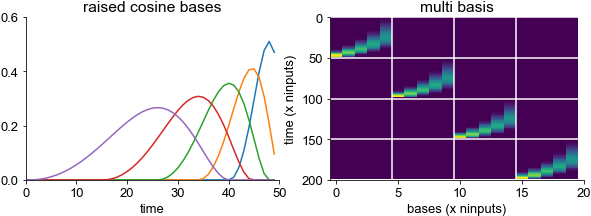

In [4]:
# define bases
B = raised_cosine(0, 5, [1, 23], 9, window_size)
B_multi = multifeature_basis(B, ninputs)  # should explain what/why we do this here
basis_multi_projection = BasisProjection(B_multi)  # should explain what/why we do this here
window_size, nbases = B.shape

plt.figure(figsize = [10,3])
plt.subplot(121)
plt.plot(B)
plt.title('raised cosine bases')
plt.xlabel('time')

plt.subplot(122) # more info on this plot, such as better axis and division labels
plt.imshow(B_multi)
plt.hlines(np.arange(0, ninputs*window_size,window_size), -0.5, B_multi.shape[1], colors='w')
plt.vlines(np.arange(0, ninputs*nbases,nbases)-0.5, 0, B_multi.shape[0], colors='w')
plt.axis('tight')
plt.ylabel('time (x ninputs)')
plt.xlabel('bases (x ninputs)')
plt.title('multi basis')
plt.show()

# Project
`I feel like this should come before the train-test split...`

The time embedded features can be projected onto the basis using  `transform`.

In [5]:
Xmulti_b = basis_multi_projection.transform(Xmulti)
print(f'Before [T, delays]: {Xmulti.shape}')
print(f'After [T, bases]: {Xmulti_b.shape}')

Before [T, delays]: (4950, 200)
After [T, bases]: (4950, 20)


# Split data into training and test sets

`Why split? Prevent overfitting...
Use https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?`

In order to train and test our models, we need to split our data. This is also required to test multiple models with the same data points. There is many ways to do this split of data. Here we will split the data into 3:1 train to test ratio. In order to keep the same test group across all examples, we will save the indices of the train/test data points.

In [6]:
# choose how many random samples to take from the data (less or equal than the available data, npoints)
ntestsamples = int(ymulti.shape[0]/3)
test_idxs = np.random.choice(np.arange(ymulti.shape[0]),ntestsamples,replace=False)
train_idxs = np.squeeze(np.argwhere(~np.isin(np.arange(ymulti.shape[0]),test_idxs)))
print(f"test_idxs: {test_idxs.shape}, train_idxs: {train_idxs.shape}")


test_idxs: (1650,), train_idxs: (3300,)


# Fit a model
We can now fit a glm model using the training data. To assess model performance, we score the model with the test data. In our case (LinearRegression) the score is the coefficient of determination, and the model predicts the data perfectly (score 1.0).

Note: The choice of model depends on the type of response you are trying to predict. For instance, for predicting binary response (song or no song), use `lm.LogisticRegression`.

In [7]:
lr = lm.LinearRegression()
lr.fit(Xmulti_b[train_idxs], ymulti[train_idxs])
print(f'score: {lr.score(Xmulti_b[test_idxs], ymulti[test_idxs]):1.2f}')

score: 1.00


# Filter reconstruction
To interpret the model we need to reconstruct the filters for each feature. If all features were normalized prior to fitting, then the filter magnitude (L2 norm) corresponds to the "importance" of each feature. The shape of the filters depicts how information from the features is integrated over time to produce the response.

The coefficients of our linear model, `lr.coef_`, correspond to weights for the different basis functions. We can use the `inverse_transform` method of the `BasisProjection` class to reconstruct the filters from these weights. Since the model was fit with features that were concatenated, the reconstructed filters for each feature will also be concatened, so we need to reshape them.

Text(0.5, 1.0, 'Filters')

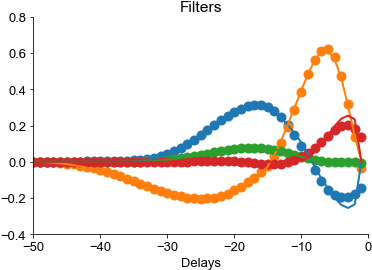

In [8]:
basis_weights = lr.coef_
estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
estimated_filters = estimated_filters.reshape((-1,window_size))

plt.plot(T, estimated_filters.T, 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(T, filters, linewidth=2)
plt.xlabel('Delays')
plt.title('Filters')

# Model performance and filter shapes with noisy responses
Now, let's see what would happen if the responses are noisy. We can fit the model with different levels of noise added to the response, making the match between inputs and signal imperfect.

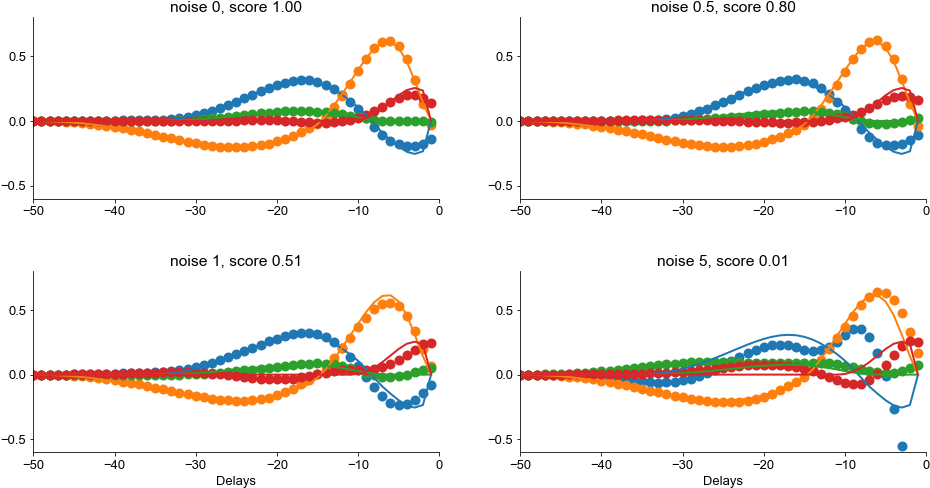

In [9]:
noise_levels = [0, 0.5, 1, 5]
plt.figure(figsize=(16, 8))
for jj, noise_level in enumerate(noise_levels):
    
    # add noise to the response
    y_noisy = ymulti + np.random.normal(ymulti.mean(), ymulti.std(), ymulti.shape[0])*noise_level # add noise to signal

    # train
    lr = lm.LinearRegression()
    lr.fit(Xmulti_b[train_idxs], y_noisy[train_idxs])

    # reconstruct
    basis_weights = lr.coef_
    estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
    estimated_filters = estimated_filters.reshape((-1,window_size))

    # plot
    plt.subplot(2, 2, jj+1)
    plt.plot(T, estimated_filters.T, 'o', linewidth=2, markersize=10)
    plt.ylim([-0.6, 0.8])
    plt.gca().set_prop_cycle(None)
    plt.plot(T, filters, linewidth=2)
    plt.title(f'noise {noise_level}, score {lr.score(Xmulti_b[test_idxs], y_noisy[test_idxs]):0.2f}')
    if jj > 1:
        plt.xlabel('Delays')
plt.subplots_adjust(hspace=0.4)
plt.show()

 The performance of the model decreases with the noise level, but the overall shape of the filters is relatively stable, even for the highest noise level.

# Missing input features
What happens to the model performance and the filter shapes if we can't measure all relevant features? To emulate this, we will fit a model using only the first two features.

Note: Because we are modifying the number of inputs, we also need to create a new `multifeature_basis` and a new `BasisProjection`. The nature of the bases will be the same. We will also keep the train/test indices from before.

incomplete model score: 0.95


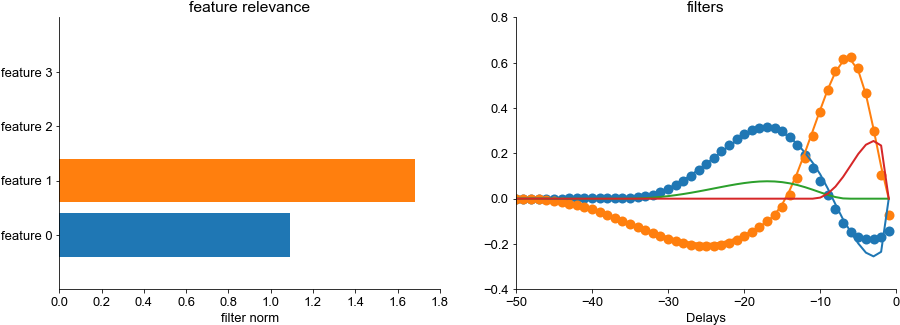

In [10]:
ninputs_incomplete = 2

# bases
B_incomplete = multifeature_basis(B, ninputs_incomplete)  # should explain what/why we do this here
basis_projection_incomplete = BasisProjection(B_incomplete)  # should explain what/why we do this here

# time-delay-embedding
X_incomplete, ymulti = time_delay_embedding(x[:, :2], y, window_size=window_size, flatten_inside_window=True)

# project
X_incomplete_b = basis_projection_incomplete.transform(X_incomplete)

# train
lr = lm.LinearRegression()
lr.fit(X_incomplete_b[train_idxs], ymulti[train_idxs])
print(f'incomplete model score: {lr.score(X_incomplete_b[test_idxs], ymulti[test_idxs]):1.2f}')

# reconstruct
basis_weights = lr.coef_
estimated_filters = basis_projection_incomplete.inverse_transform(basis_weights)
estimated_filters = estimated_filters.reshape((-1,window_size))

# filter norm
filt_norms = np.linalg.norm(estimated_filters, axis=1)

# plot
features_names = [f'feature {ii}' for ii in range(ninputs)]
plt.figure(figsize=[15,5])
plt.subplot(121)
for ii in range(ninputs_incomplete):
    plt.barh(ii, filt_norms[ii])
plt.yticks(np.arange(ninputs),features_names)
plt.xlabel('filter norm')
plt.title('feature relevance')
plt.ylim([-1,4])
plt.subplot(122)
plt.plot(T,estimated_filters.T, 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(T,filters, linewidth=2)
plt.xlabel('Delays')
plt.title('filters')
plt.show()

Omitting features reduces the model performance, but the filters for the remaining features are correctly reconstructed.

# Irrelevant input features

Another common situation is providing the model with features that are not relevant for the response. In this example, we will add a new feature to our set of inputs, but it will consist of a sample from a normal distribution, non-related with the signal. As in the previous example, we are changing the number of inputs in our model, therefore we need to create a new BasisProjection. We keep the same train/test indices as before.

irrelevant model score: 1.00


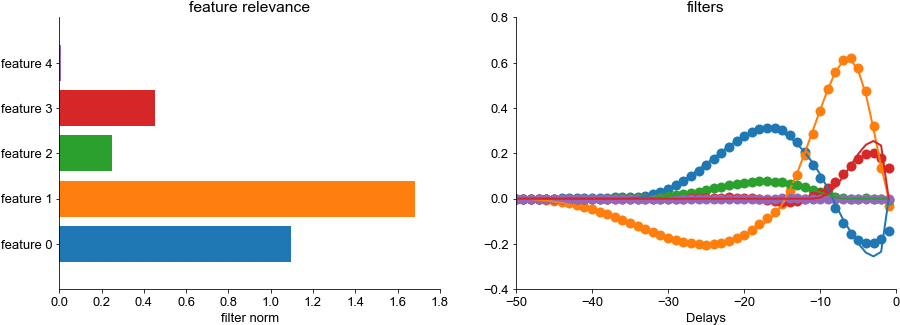

In [11]:
# data
x_irrelevant = np.concatenate((x,np.random.normal(0, 1, x[:,0].shape)[:,np.newaxis]),axis=1)

# bases
B_irrelevant = multifeature_basis(B, ninputs+1)  # should explain what/why we do this here
basis_projection_irrelevant = BasisProjection(B_irrelevant)  # should explain what/why we do this here

# time-delay-embedding
X_irrelevant, ymulti = time_delay_embedding(x_irrelevant, y, window_size=window_size, flatten_inside_window=True)

# project
X_irrelevant_b = basis_projection_irrelevant.transform(X_irrelevant)

# train
lr = lm.LinearRegression()
lr.fit(X_irrelevant_b[train_idxs], ymulti[train_idxs])
print(f'irrelevant model score: {lr.score(X_irrelevant_b[test_idxs], ymulti[test_idxs]):1.2f}')

# reconstruct
basis_weights = lr.coef_
estimated_filters = basis_projection_irrelevant.inverse_transform(basis_weights)
estimated_filters = estimated_filters.reshape((-1,window_size))

# filter norm
filt_norms = np.linalg.norm(estimated_filters, axis=1)

# plot
features_names = [f'feature {ii}' for ii in range(ninputs+1)]
plt.figure(figsize=[15,5])
plt.subplot(121)
for ii in range(ninputs+1):
    plt.barh(ii,filt_norms[ii])
plt.yticks(np.arange(ninputs+1),features_names)
plt.xlabel('filter norm')
plt.title('feature relevance')
plt.subplot(122)
plt.plot(T,estimated_filters.T, 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(T,filters, linewidth=2)
plt.xlabel('Delays')
plt.title('filters')
plt.show()



The model "recognizes" the new feature as irrelevant, and sets the coefficients and the filter for the irrelevant feature to zero. For real  data, even irrelevant features often have some correlation with relevant features, and even irrelevant features will get some weight in the model. Inspecting the norm and the shape of the filters should help spot those cases. Alternatively, you can use regularization, which suppresses contributions from unimportant features (see below and [basics.ipynb](basics.ipynb)).

# Single- vs. multi-feature models

All models so far were _multi-feature models_ - a model was fit with multiple features. An alternative approach is to fit and compare _single-feature models_ - one model per feature. To demonstrate the advantages of a multi-feature model, we will compare it to single-feature models.

In order to do this, let's continue using our previous example with an irrelevant feature. We already have the results for the multi-feature model, so let's save those for later.

In [12]:
# save previous results for comparison
integrated_model_filters = estimated_filters
integrated_model_score = lr.score(X_irrelevant_b[test_idxs], ymulti[test_idxs])

Now using the same steps as before - time delay embedding, basis projection, model fitting, scoring, and filter reconstruction - but using only one feature at a time, generating 5 single-feature models.

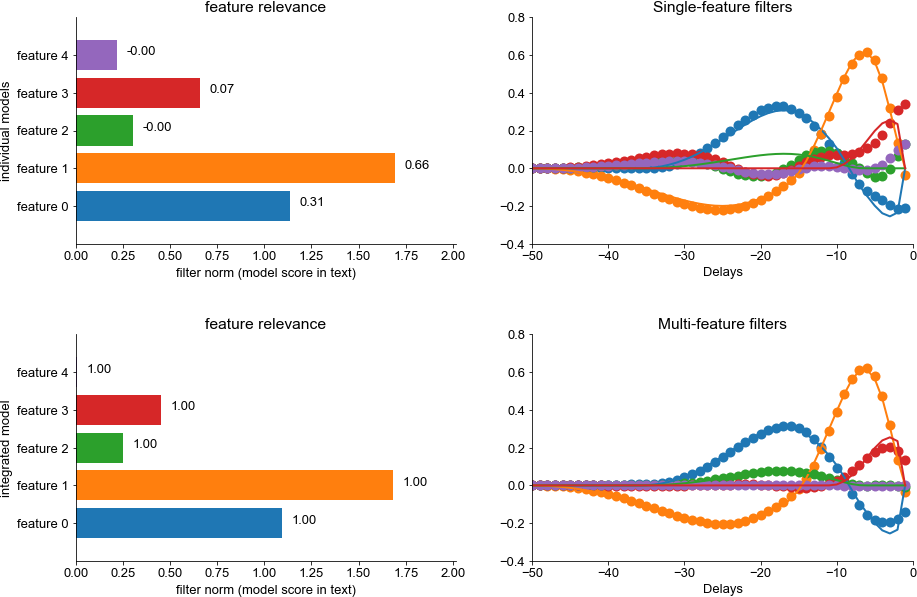

In [13]:
# indidivual basis
basis_projection = BasisProjection(B)

# lists to collect results per individual model
scores_list = []
estimated_filters_list = []

# loop through all the inputs
for ii in range(ninputs+1):

    # time-delay-embedding
    Xs, ys = time_delay_embedding(x_irrelevant[:,ii], y, window_size=window_size, flatten_inside_window=True)

    # project
    Xs_b = basis_projection.transform(Xs)

    # train
    lr = lm.LinearRegression()
    lr.fit(Xs_b[train_idxs], ys[train_idxs])

    # reconstruct
    basis_weights = lr.coef_
    estimated_filters = basis_projection.inverse_transform(basis_weights)
    estimated_filters = estimated_filters.reshape((-1,window_size))

    # save results
    scores_list.append(lr.score(Xs_b[test_idxs], ys[test_idxs]))
    estimated_filters_list.append(np.squeeze(estimated_filters))


# plot
features_names = [f'feature {ii}' for ii in range(ninputs+1)]
estimated_filters = np.asarray(estimated_filters_list)
filt_norms = np.linalg.norm(estimated_filters, axis=1)
int_filt_norms = np.linalg.norm(integrated_model_filters, axis=1)

plt.figure(figsize=[15,10])
plt.subplot(221)
for ii in range(ninputs+1):
    plt.barh(ii,filt_norms[ii])
    plt.text(filt_norms[ii]+0.05, ii, s=f"{scores_list[ii]:0.2f}")
plt.yticks(np.arange(ninputs+1),features_names)
plt.xlabel('filter norm (model score in text)')
plt.title('feature relevance')
plt.ylabel('individual models')
plt.xlim([0,np.max(int_filt_norms)*1.2])
plt.subplot(222)
for ii in range(ninputs+1):
    plt.plot(T,estimated_filters_list[ii], 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(T,filters, linewidth=2)
plt.xlabel('Delays')
plt.title('Single-feature filters')

plt.subplot(223)
for ii in range(ninputs+1):
    plt.barh(ii,int_filt_norms[ii])
    plt.text(int_filt_norms[ii]+0.05, ii, s=f"{integrated_model_score:0.2f}")
plt.yticks(np.arange(ninputs+1),features_names)
plt.xlabel('filter norm (model score in text)')
plt.title('feature relevance')
plt.ylabel('integrated model')
plt.xlim([0,np.max(int_filt_norms)*1.2])
plt.subplot(224)
plt.plot(T,integrated_model_filters.T, 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(T,filters, linewidth=2)
plt.xlabel('Delays')
plt.title('Multi-feature filters')
plt.subplots_adjust(hspace=0.4)
plt.show()


You can see, the multi-feature model better "detects" the irrelevant feature - it sets the filter for that feature to zero. By contrast, the single-feature model for the multi feature model produces a zero score but  a non-zero filter.'

# Redundant features

In the next example we will demonstrate what happens in the presence of redundant (a.k.a. colinear) features. In this example the redundant feature is constructed by adding two of our previous features - the new feature 4 is partly redundant with features 1 and 2.

We will introduce a new type of model in this example, called Lasso. The LASSO minimizes the number of non-zero coefficients while maximizing the model performance through a process called _regularization_. In a way, this is Occam's razor applied to generalized linear models. 

Regularization successfully reduces the weights for redundant features. However, the magnitudes and shapes of the remaining filters are also slightly distorted  in the process. The correct level of regularization should be determined using crossvalidation.

Standard linear regression, model score: 1.00
LASSO, model score: 0.96


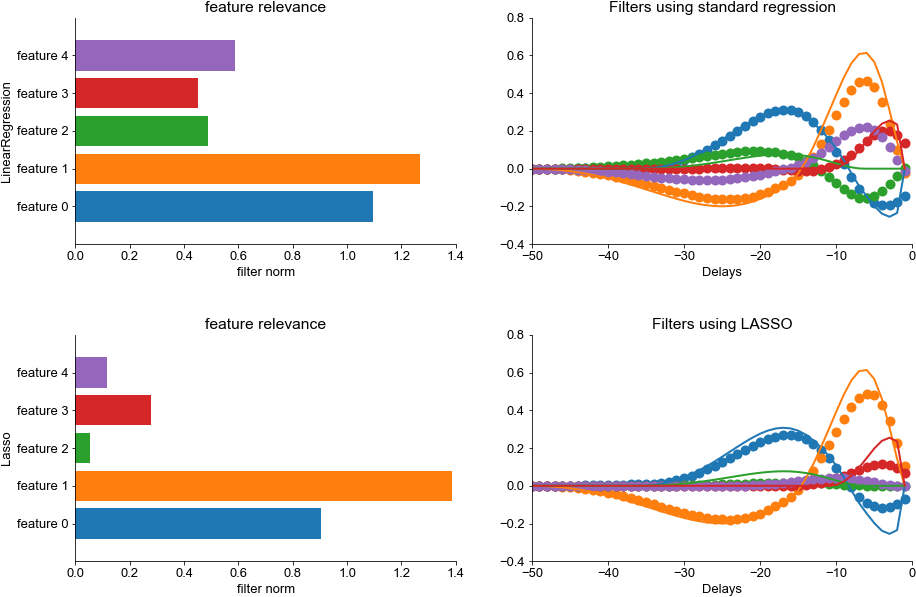

In [14]:
# data
x_redundant = np.concatenate((x,x[:,[1]]+x[:,[2]]),axis=1)
x_redundant[:,-1] = (x_redundant[:,-1] - np.mean(x_redundant[:,-1]))/np.std(x_redundant[:,-1]) # normalize new feature

# bases
B_redundant = multifeature_basis(B, ninputs+1)  # should explain what/why we do this here
basis_projection_redundant = BasisProjection(B_redundant)  # should explain what/why we do this here

# time-delay-embedding
X_redundant, ymulti = time_delay_embedding(x_redundant, y, window_size=window_size, flatten_inside_window=True)

# project
X_redundant_b = basis_projection_redundant.transform(X_redundant)

# train
lr = lm.LinearRegression()
lr.fit(X_redundant_b[train_idxs], ymulti[train_idxs])
print(f'Standard linear regression, model score: {lr.score(X_redundant_b[test_idxs], ymulti[test_idxs]):1.2f}')

# train (with lasso)
lr_lasso = lm.Lasso()
lr_lasso.fit(X_redundant_b[train_idxs], ymulti[train_idxs])
print(f'LASSO, model score: {lr_lasso.score(X_redundant_b[test_idxs], ymulti[test_idxs]):1.2f}')

# reconstruct
basis_weights = lr.coef_
estimated_filters = basis_projection_redundant.inverse_transform(basis_weights)
estimated_filters = estimated_filters.reshape((-1,window_size))

# reconstruct (with lasso)
basis_weights_lasso = lr_lasso.coef_
estimated_filters_lasso = basis_projection_redundant.inverse_transform(basis_weights_lasso)
estimated_filters_lasso = estimated_filters_lasso.reshape((-1,window_size))

# relevance plot for lr
features_names = [f'feature {ii}' for ii in range(ninputs+1)]
plt.figure(figsize=[15,10])
plt.subplot(221)
for ii in range(ninputs+1):
    filt_norm = np.linalg.norm(estimated_filters[ii])
    plt.barh(ii, filt_norm)
plt.yticks(np.arange(ninputs+1),features_names)
plt.xlabel('filter norm')
plt.title('feature relevance')
plt.ylabel('LinearRegression')
plt.subplot(222)
plt.plot(T,estimated_filters.T, 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(T,filters, linewidth=2)
plt.xlabel('Delays')
plt.title('Filters using standard regression')

# relevance plot for lasso
plt.subplot(223)
for ii in range(ninputs+1):
    filt_norm = np.linalg.norm(estimated_filters_lasso[ii])
    plt.barh(ii,filt_norm)
plt.yticks(np.arange(ninputs+1),features_names)
plt.xlabel('filter norm')
plt.title('feature relevance')
plt.ylabel('Lasso')
plt.subplot(224)
plt.plot(T,estimated_filters_lasso.T, 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(T,filters, linewidth=2)
plt.xlabel('Delays')
plt.title('Filters using LASSO')
plt.subplots_adjust(hspace=0.4,wspace=0.2)
plt.show()